In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph, get_pos_init_graph, plot_graph, get_neighbors_graph
import run_exp
import regularization

In [3]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage, DigMontage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

import wandb
import pickle

In [4]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

import pathlib

In [5]:
from IPython.display import clear_output

In [6]:
plt.imshow(get_pos_init_graph(eloc), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

NameError: name 'eloc' is not defined

In [10]:
positions = eloc.get_positions()['ch_pos']
points = np.stack(list(positions.values()))
ch_names = dict(enumerate(positions.keys()))

In [11]:
torch.manual_seed(44)
np.random.seed(44)

A_init = torch.empty(64, 64)
k = math.sqrt(1 / (64 * 64))
nn.init.uniform_(A_init, -k, k)
A_init = (A_init + A_init.T) / 2

A_init

tensor([[ 6.8622e-03,  1.0667e-02,  3.4481e-03,  ..., -2.1118e-03,
          5.2476e-03,  9.8840e-03],
        [ 1.0667e-02,  5.4418e-04,  3.9523e-03,  ...,  2.1553e-03,
          6.6262e-03,  3.1635e-04],
        [ 3.4481e-03,  3.9523e-03, -6.8051e-03,  ...,  1.0208e-04,
         -5.5562e-04,  3.8470e-03],
        ...,
        [-2.1118e-03,  2.1553e-03,  1.0208e-04,  ...,  1.4679e-02,
          2.0596e-03,  1.4644e-04],
        [ 5.2476e-03,  6.6262e-03, -5.5562e-04,  ...,  2.0596e-03,
         -1.1903e-02,  2.9926e-03],
        [ 9.8840e-03,  3.1635e-04,  3.8470e-03,  ...,  1.4644e-04,
          2.9926e-03,  9.0171e-06]])

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\935147045.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\935147045.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\935147045.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\935147045.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\935147045.py:9: Depreca

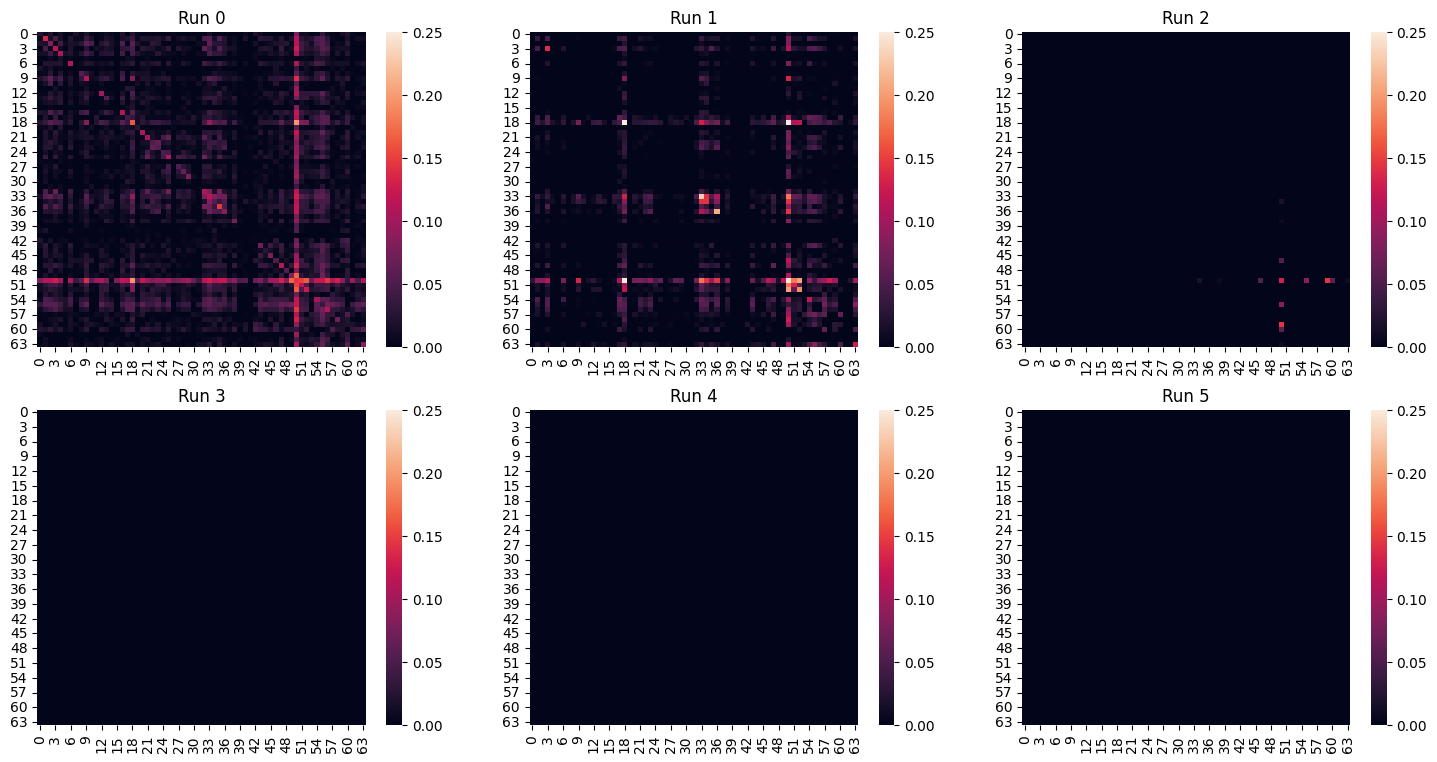

In [11]:
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 9))

with open('../A_random_l1_dump.bin', 'rb') as f:
    A_res_l1 = pickle.load(f)

for idx, A_trained in enumerate(A_res_l1):
    i, j = divmod(idx, 3)
    sns.heatmap(
        data=np.abs(A_trained),
        ax=ax[i, j],
        vmin=0,
        vmax=0.25,
        # norm=LogNorm()
    )
    ax[i, j].set_title(f'Run {idx}')

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\746327480.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\746327480.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\746327480.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\746327480.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\746327480.py:9: Depreca

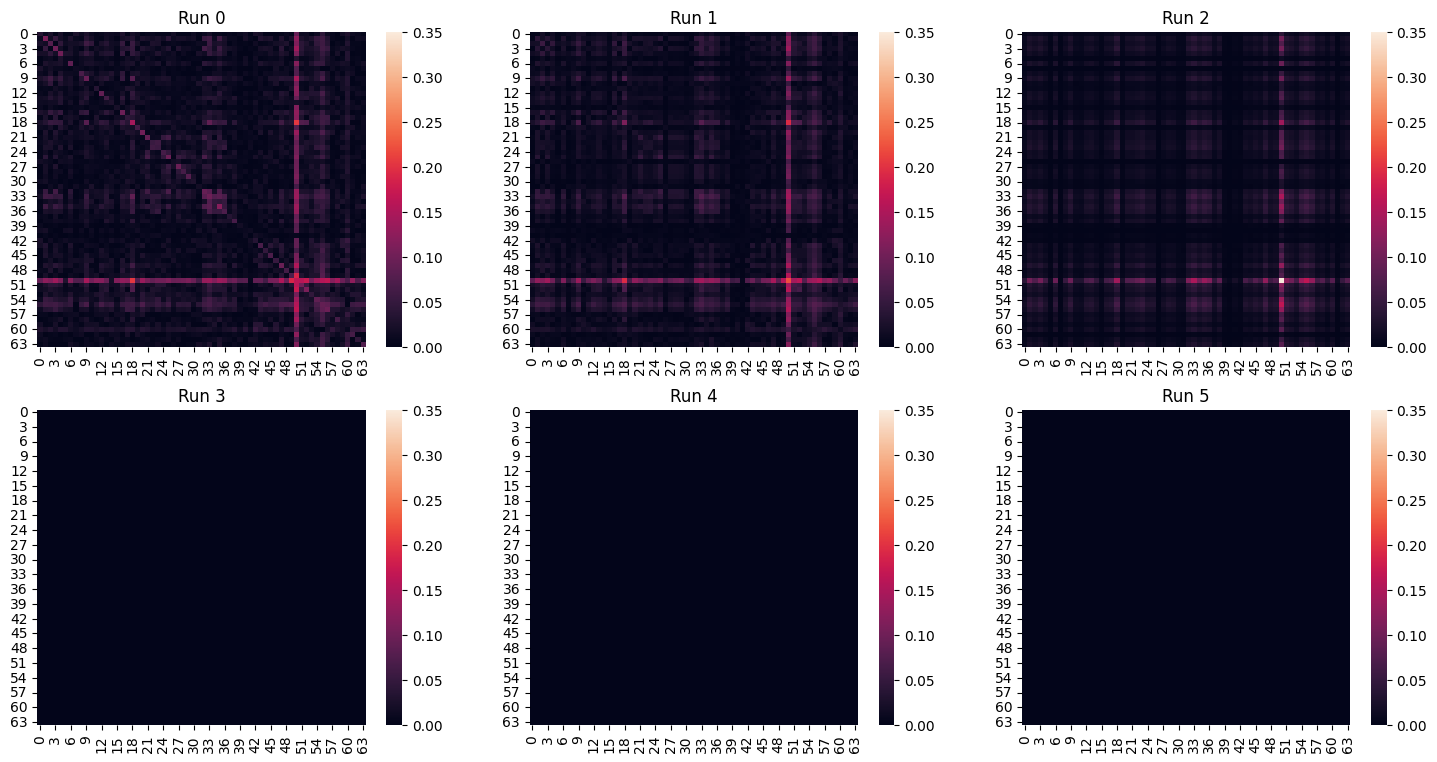

In [14]:
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 9))

with open('../A_random_nuc_dump.bin', 'rb') as f:
    A_random_nuc = pickle.load(f)

for idx, A_trained in enumerate(A_random_nuc):
    i, j = divmod(idx, 3)
    sns.heatmap(
        data=np.abs(A_trained),
        ax=ax[i, j],
        vmin=0,
        vmax=0.35,
    )
    ax[i, j].set_title(f'Run {idx}')

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\551235735.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\551235735.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\551235735.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\551235735.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\551235735.py:9: Depreca

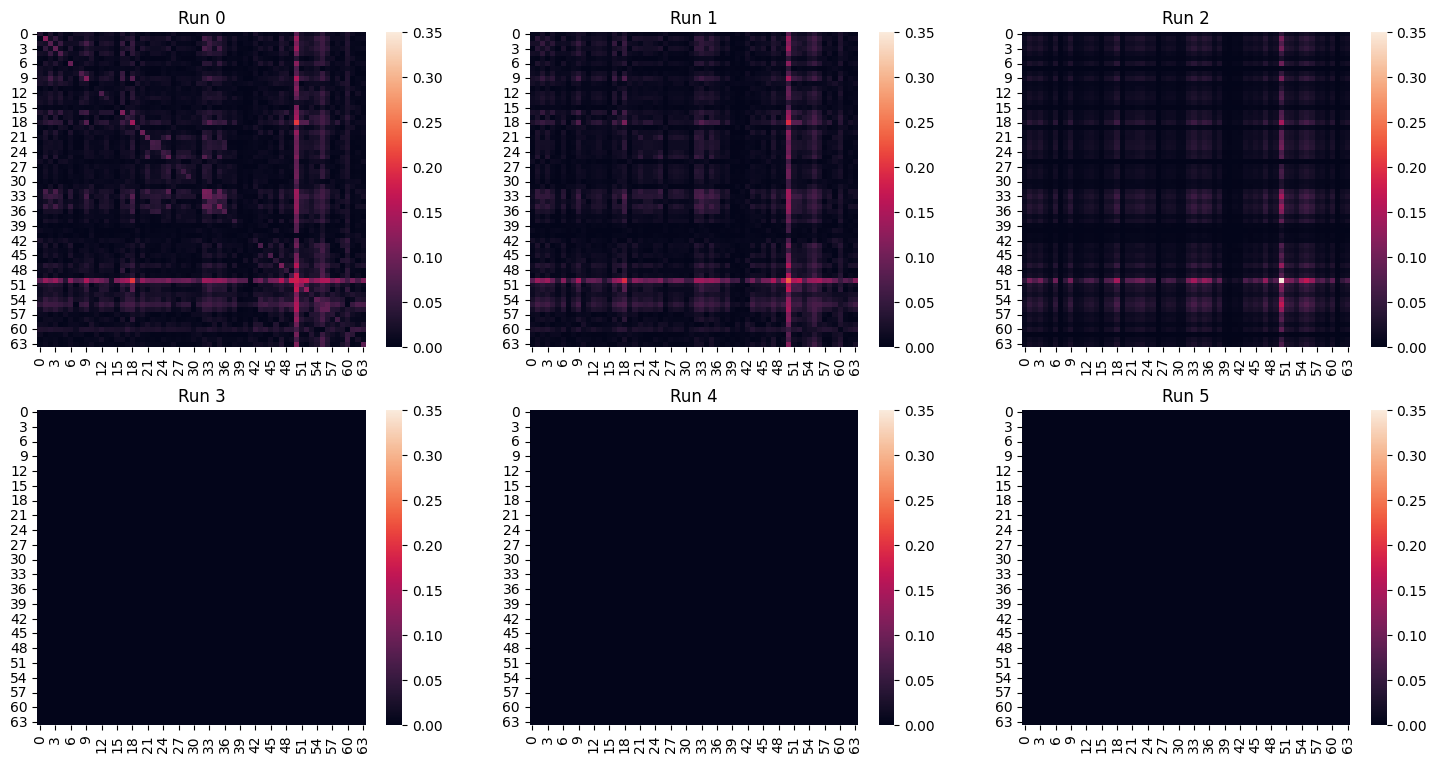

In [17]:
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 9))

with open('../A_zero_nuc_dump.bin', 'rb') as f:
    A_zero_nuc = pickle.load(f)

for idx, A_trained in enumerate(A_zero_nuc):
    i, j = divmod(idx, 3)
    sns.heatmap(
        data=np.abs(A_trained),
        ax=ax[i, j],
        vmin=0,
        vmax=0.35,
    )
    ax[i, j].set_title(f'Run {idx}')

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\845454748.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\845454748.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\845454748.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\845454748.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\845454748.py:9: Depreca

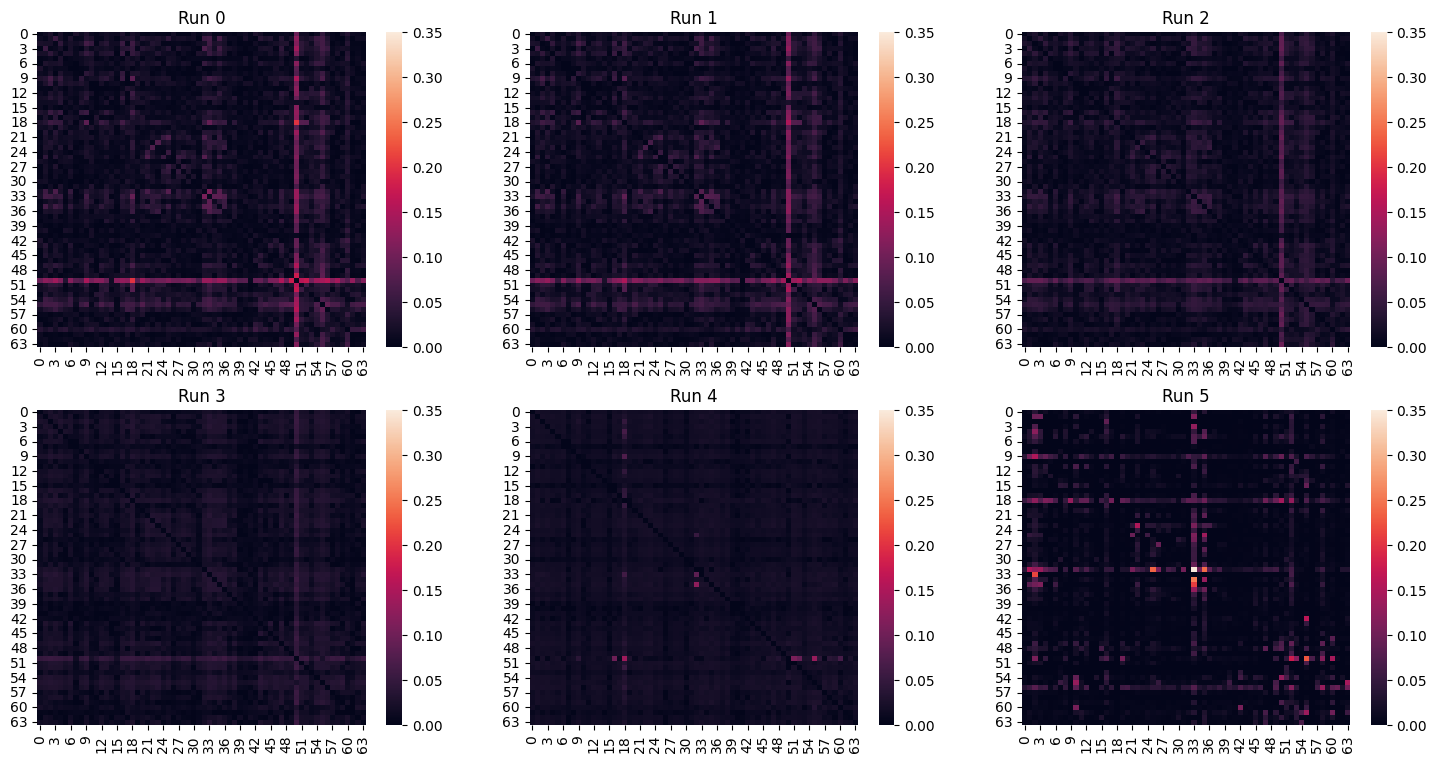

In [20]:
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 9))

with open('../A_random_acyclic_dump.bin', 'rb') as f:
    A_random_acyclic = pickle.load(f)

for idx, A_trained in enumerate(A_random_acyclic):
    i, j = divmod(idx, 3)
    sns.heatmap(
        data=np.abs(A_trained),
        ax=ax[i, j],
        # norm=LogNorm()
        vmin=0,
        vmax=0.35,
    )
    ax[i, j].set_title(f'Run {idx}')

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\3209792981.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\3209792981.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\3209792981.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\3209792981.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\3209792981.py:9: De

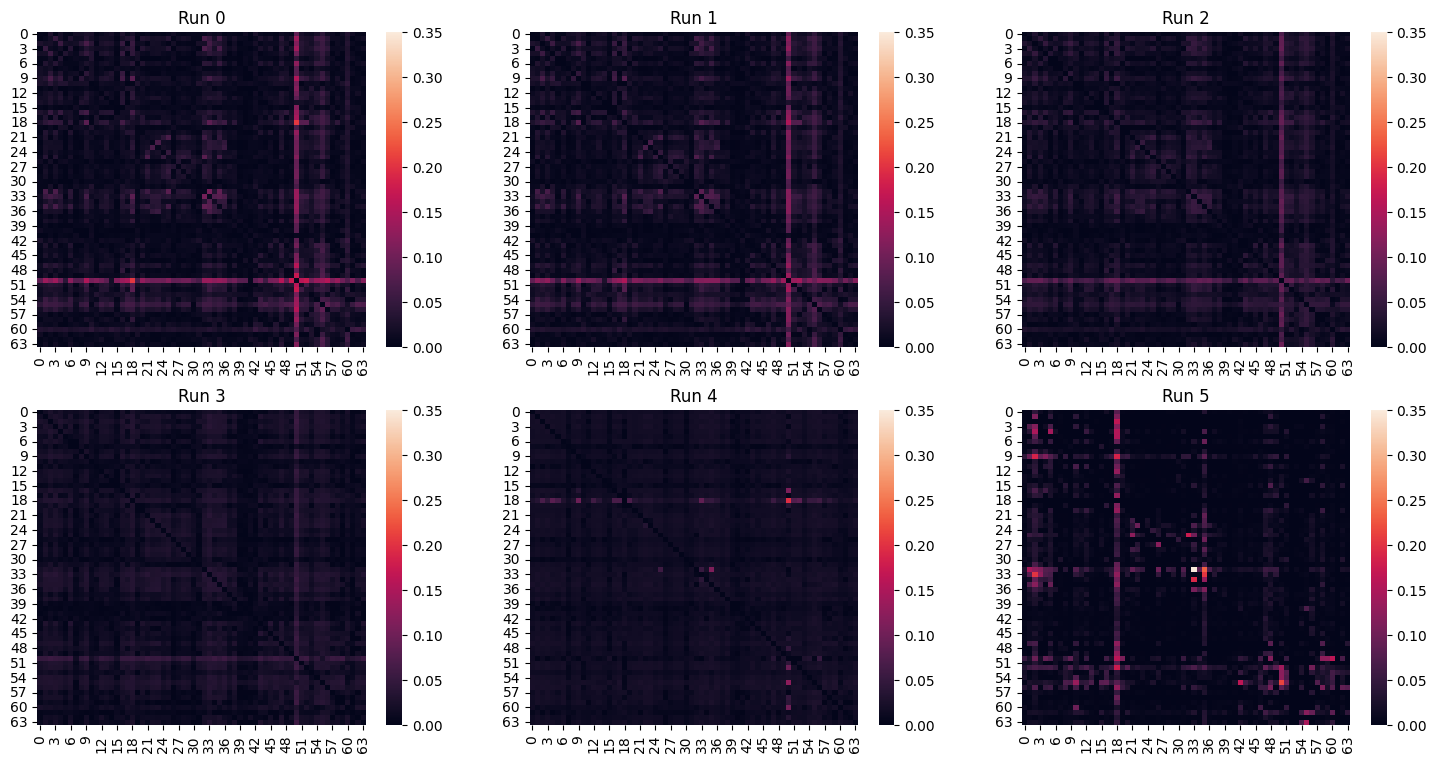

In [21]:
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 9))

with open('../A_zero_acyclic_dump.bin', 'rb') as f:
    A_random_acyclic = pickle.load(f)

for idx, A_trained in enumerate(A_random_acyclic):
    i, j = divmod(idx, 3)
    sns.heatmap(
        data=np.abs(A_trained),
        ax=ax[i, j],
        # norm=LogNorm()
        vmin=0,
        vmax=0.35,
    )
    ax[i, j].set_title(f'Run {idx}')

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\1408641878.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\1408641878.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\1408641878.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\1408641878.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17416\1408641878.py:9: De

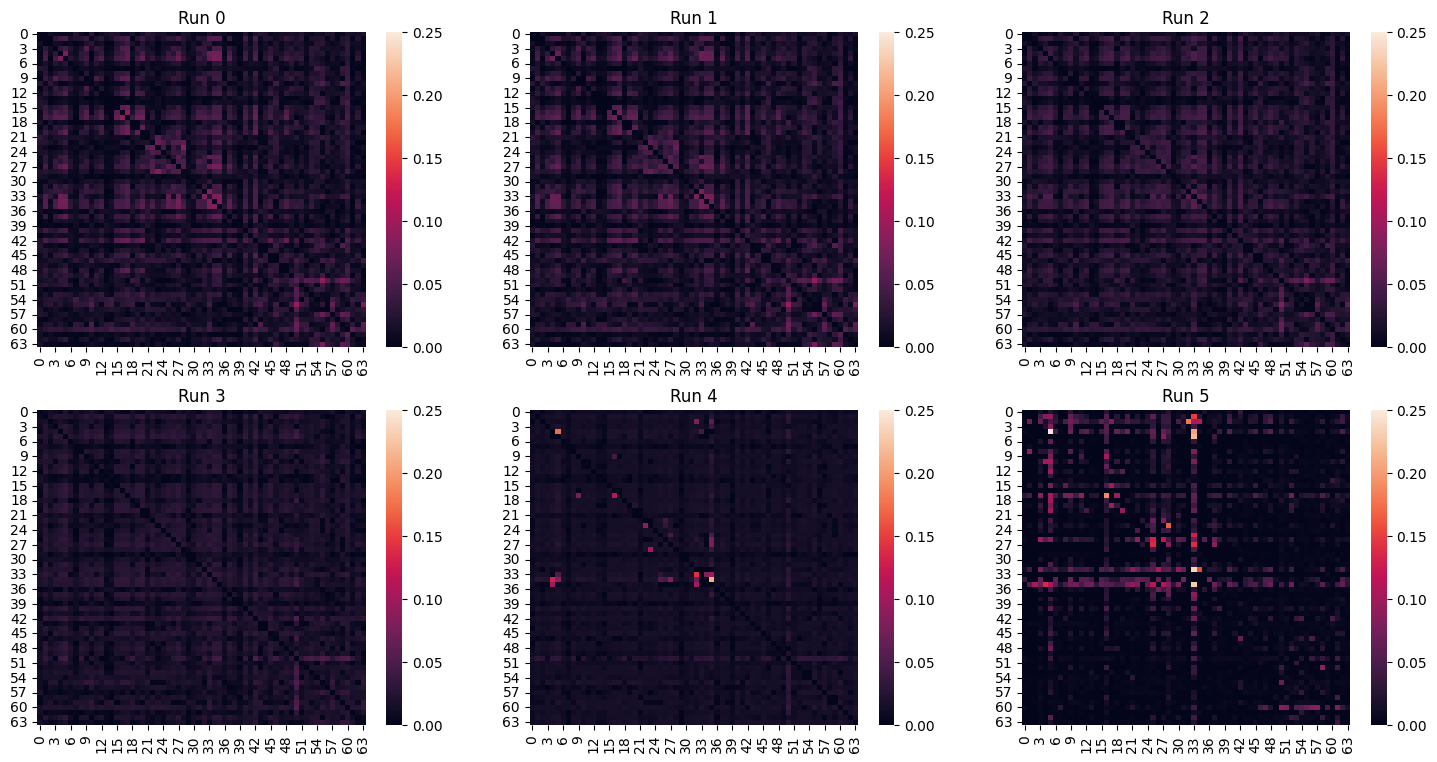

In [24]:
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 9))

with open('../A_zero_acyclic_sd_dump.bin', 'rb') as f:
    A_random_acyclic_sd = pickle.load(f)

for idx, A_trained in enumerate(A_random_acyclic_sd):
    i, j = divmod(idx, 3)
    sns.heatmap(
        data=np.abs(A_trained),
        ax=ax[i, j],
        # norm=LogNorm()
        vmin=0,
        vmax=0.25,
    )
    ax[i, j].set_title(f'Run {idx}')